In [1]:
pip install folium

   ---------------------------------------- 0.0/110.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/110.5 kB ? eta -:--:--
   ------- ------------------------------- 20.5/110.5 kB 330.3 kB/s eta 0:00:01
   --------------------- ----------------- 61.4/110.5 kB 656.4 kB/s eta 0:00:01
   -------------------------------------- 110.5/110.5 kB 919.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Importing libraries

In [9]:
# Import libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import folium
import json

In [11]:
%matplotlib inline

# Importing data

In [18]:
# Import the data files
path=r'C:\Users\asicz\OneDrive\Dokumenty\CareerFoundry_Data_Analyst_Course\Data Immersion\Achievement 6'
evo_data=pd.read_csv(os.path.join(path, 'corrected_evo_data.csv'), index_col = False)
geo_data_path = os.path.join(path, 'countries.geo.json')

In [24]:
geo = open(geo_data_path,)

In [28]:
geo_data = json.load(geo)

In [30]:
# Iterating through the json list
for i in geo_data['features']:
    print(i)

{'type': 'Feature', 'id': 'AFG', 'properties': {'name': 'Afghanistan'}, 'geometry': {'type': 'Polygon', 'coordinates': [[[61.210817, 35.650072], [62.230651, 35.270664], [62.984662, 35.404041], [63.193538, 35.857166], [63.982896, 36.007957], [64.546479, 36.312073], [64.746105, 37.111818], [65.588948, 37.305217], [65.745631, 37.661164], [66.217385, 37.39379], [66.518607, 37.362784], [67.075782, 37.356144], [67.83, 37.144994], [68.135562, 37.023115], [68.859446, 37.344336], [69.196273, 37.151144], [69.518785, 37.608997], [70.116578, 37.588223], [70.270574, 37.735165], [70.376304, 38.138396], [70.806821, 38.486282], [71.348131, 38.258905], [71.239404, 37.953265], [71.541918, 37.905774], [71.448693, 37.065645], [71.844638, 36.738171], [72.193041, 36.948288], [72.63689, 37.047558], [73.260056, 37.495257], [73.948696, 37.421566], [74.980002, 37.41999], [75.158028, 37.133031], [74.575893, 37.020841], [74.067552, 36.836176], [72.920025, 36.720007], [71.846292, 36.509942], [71.262348, 36.074388]

# Data wrangling & Consistency check

In [35]:
# Keep only the columns necessary for the analysis
columns = ["Time", "Cranial_Capacity", "Genus_&_Species", "Location", "Zone", "Current_Country"]

In [37]:
# Create a subset with these columns
evo_geo = evo_data[columns]

In [39]:
evo_geo.head()

,Time,Cranial_Capacity,Genus_&_Species,Location,Zone,Current_Country
0,6.041124,144.51410,hominino Orrorin tugenencin,Africa,oriental,Kenya
1,4.383910,293.96021,hominino Ardipithecus ramidus / kabadda,Africa,oriental,Ethiopia
2,3.749413,264.79849,Australopithecus Afarensis,Africa,oriental,Kenya
3,4.595606,403.28047,Australopithecus Anamensis,Africa,oriental,Kenya
4,3.614060,679.15233,Australopithecus Africanus,Africa,south,South Africa


In [41]:
# Check for missing values
evo_geo.isnull().sum()

Time                0
Cranial_Capacity    0
Genus_&_Species     0
Location            0
Zone                0
Current_Country     0
dtype: int64

In [104]:
duplicates = evo_geo.duplicated()

In [106]:
dups.shape

(12000,)

<Axes: xlabel='Cranial_Capacity', ylabel='Count'>

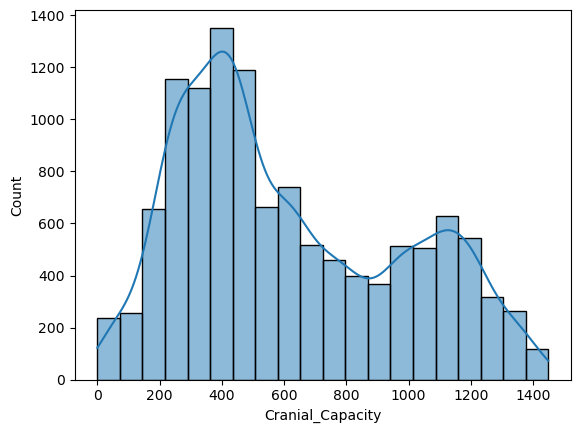

In [44]:
# Check for extreme values in Cranial Capacity
sns.histplot(evo_geo['Cranial_Capacity'], bins=20, kde = True) 

In [52]:
# Check for entries in Location
unique_locations = evo_data['Location'].unique()
print(unique_locations)

['Africa' 'Europa' 'Asia ']


In [46]:
# Check for entries in Current Country
unique_countries = evo_data['Current_Country'].unique()
print(unique_countries)

['Kenya' 'Ethiopia' 'South Africa' 'Republic of Chad' 'Germany'
 'Indonesia' 'Spain' 'Georgia']


# Plotting choropleth

In [63]:
# Setup a folium map at a high-level zoom
map = folium.Map(location = [100, 0], zoom_start = 1.5)

# Choropleth maps 
folium.Choropleth(
    geo_data = geo_data, 
    data = evo_geo,
    columns = ['Current_Country', 'Cranial_Capacity'],
    key_on = 'feature.properties.name', 
    fill_color = 'YlOrBr', fill_opacity=0.6, line_opacity=0.1,
    legend_name = "Cranial Capacity of Hominins").add_to(map)
folium.LayerControl().add_to(map)

map

In [57]:
# Save the map
map.save('map_plot_hominin_brains.html')

#### We can see that there is a dependency of the Hominin brain size and location. This though includes time variable as most of those species weren't coexisting at the same time. 
#### What we see here is the out of Africa hominin migration. As during the evolution, our relatives were migrating towards Levant and further into Europe, or Eurasia. This also partially answers to the Question 2 - the Cranial Capacity of hominins is different for different regions. 
#### What  remains is to further overlay this map data with time, or more practically, with hominin species.
#### Interestingly, the hominin with a very small brain which we see in Indonesia is probably one of the outliers with a small brain and short height. It must be younger than the African species (migration out of Africa), therefore there were some environmental causes of such overall small size. We will investigate them in further analysis.

Text(104.5222222222222, 0.5, 'Genus & Species (Sorted by youngest)')

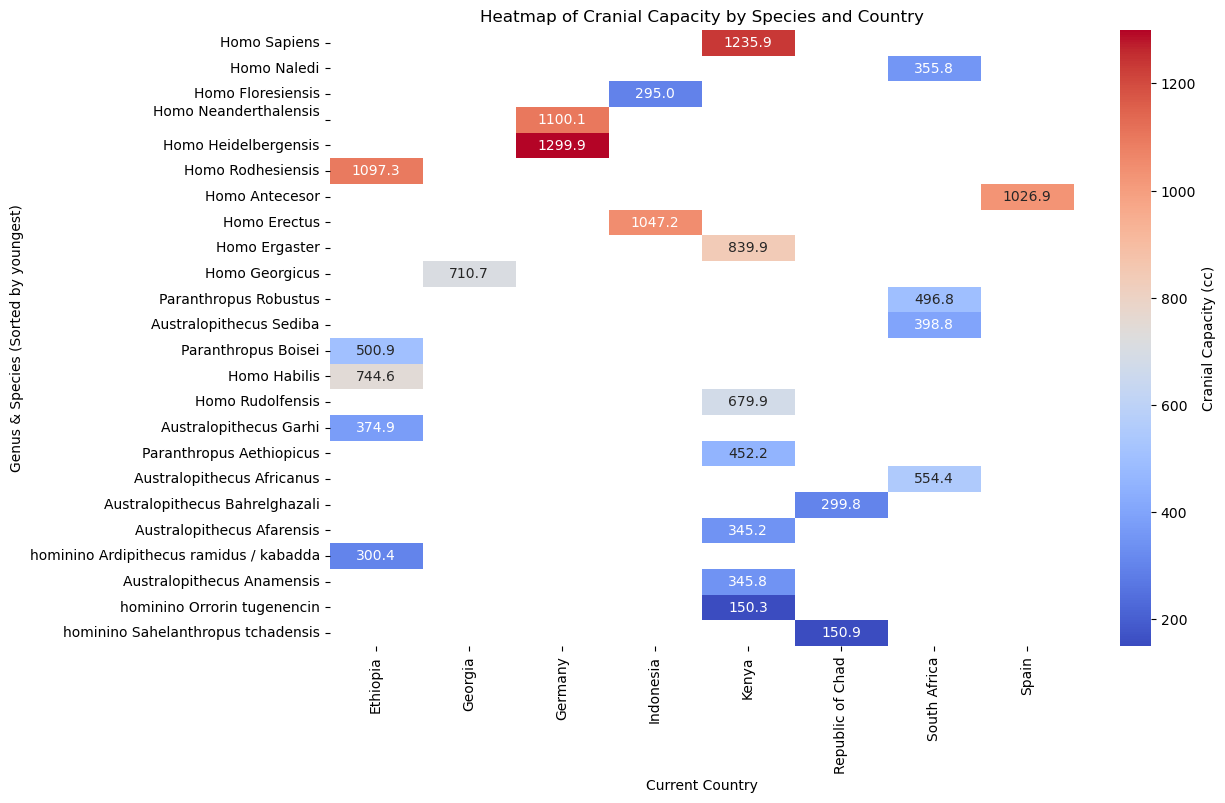

In [87]:
# Extraction of data about Hominin species over time, geographical location and their brain size.

df_filtered = evo_geo[['Genus_&_Species', 'Time', 'Current_Country', 'Cranial_Capacity']]

# Group data by species, time, and country and calculate the mean cranial capacity
df_grouped = df_filtered.groupby(['Genus_&_Species', 'Time', 'Current_Country']).agg({'Cranial_Capacity': 'mean'}).reset_index()

# Sort by youngest species on the top
df_grouped_sorted = df_grouped.sort_values(by='Time', ascending=True)
youngest_times = df_grouped_sorted.groupby('Genus_&_Species')['Time'].min().reset_index()
sorted_species = youngest_times.sort_values(by='Time', ascending=True)['Genus_&_Species'].tolist()

# Creating a pivot table with species as rows, time as columns, and cranial capacity as values
pivot_table = df_grouped_sorted.pivot_table(values='Cranial_Capacity', 
                                            index='Genus_&_Species', 
                                            columns='Current_Country', 
                                            aggfunc='mean')

pivot_table = pivot_table.loc[sorted_species]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='.1f', cbar_kws={'label': 'Cranial Capacity (cc)'})
plt.title('Heatmap of Cranial Capacity by Species and Country')
plt.xlabel('Current Country')
plt.ylabel('Genus & Species (Sorted by youngest)')

In [89]:
# Save the heatmap
plt.savefig('cranial_capacity_heatmap.png', format='png', dpi=300)

<Figure size 640x480 with 0 Axes>

#### On the heatmap above we see a general trend that the younger the hominin species, the bigger the brain size it has. And it's true for all the geographical locations, except Indonesia.
#### I have to dispute on the data of bigger Cranial Capacity of H. Heildelbergensis than  H. Neanderhthalensis. The latter one is known of the biggest brain size amongst hominins, the data here probably do not include all teh records collected for that species.
#### So certainly, these data leads us to sime interesting hints about human brain avolution. We are going to explore our Questions further, taking into account finidngs from the current analysis about Cranial Capacity of homimins in different locations and across the evolutionary time.